# ML for NFL Analysis, Part II

In the initial analysis, we identified some variables that seemed to have high importance, and some that had less high importance when it came to linear relationships with the output variable. There were also some potentially interesting inferences concerning trends over time. Today we'll take a look at more complicated variable relationships and attempt to discern higher dimensional multivariate analyses (relationships between multiple input variables and the output variable). 

As there is a lot that can be done with this data, I'd like to touch on application. At the moment, I'm still attempting to figure out the best analysis that can be done with this type of input. Analyses could potentially range from stats that contribute to concussions, how many rushes per season result in a substantially decreased effort the subsequent season, what stats contribute the most to winning and losing, outlier players at their position, or attempting to identify bets to make on games. Personally, I'm interested in all of these things, and hopefully they can all be built out over time. In order to build complexity, however, we will start simple: 

**Can we predict that a team wins, and to what degree of accuracy?**

To do this, we will need to: 
1. Capture all the positional statistics that come out of a single game. (Note: currently I only have tables for QBs, WRs, and RBs. I assume that accuracy will be increased with more data, and that is coming, in due time). I stored these results in a local sqlite DB for ease of access. Right now, I'm only using QB data from the past 10 years, as it is arguably the position that holds the most influence on a game's outcome. Obviously there are many many other factors, and the dataset will be expanded to accommodate other positions, but for a proof on concept, QB data should be enough.
2. Manipulate the data to make it ML-friendly - this involved mapping the players, teams, opponents, stripping oddly formatted fields, dropping null values, converting date strings to datetimes.
3. I decided that the best way to reflect real-life scenarios would be to split the data into game-day properies and past data - so game day properties would be the team, the opponents, the time of year, and the starting QB. For past data, I decided to aggregate the stats for every game that that starting QB has played in the past.
4. In order to optimize the training models, I used sklearn's GridSearchCV to test different combinations of parameters for each classification model. This also allowed for some control over testing parameters to decrease iteration time.
5. In the optimization class, I built in dimensionality reduction, so you can turn PCA on or off for that purpose (doesn't work on all models though).
6. Then just rank the models! I used purely test score for my ranking (the accuracy of the model in classifying data that was not included in the training set), which turned out to be very consistent across all models, which is comforting.
7. Lastly, I created a dataframe that shows the predictions for the week's games, and an aggregated prediction across all the models. We'll see how it does during week one, and optimize from there.

In [1]:
# importing standard packages and custom classes
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
from src.main.python3.NFL_data_cleaning import dataInitializer, mlOptimizer

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


## 1. Capture Positional Statistics

Here, we create a connection to the sqlite DB that houses the QB data. The first 5 rows of the 3784 row dataframe are shown here, with all the raw statistics. 

In [5]:
dataConnection = dataInitializer()
qbDf = dataConnection.fetchData('qbs')

qbDf.head().to_html()

# qbDf.head()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>date</th>\n      <th>team</th>\n      <th>opponent</th>\n      <th>result</th>\n      <th>attempts</th>\n      <th>completions</th>\n      <th>percent</th>\n      <th>yards</th>\n      <th>yards_per_attempt</th>\n      <th>touchdowns</th>\n      <th>interceptions</th>\n      <th>longest_completion</th>\n      <th>qb_rating</th>\n      <th>player_name</th>\n      <th>sacks</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>160811</td>\n      <td>Jax</td>\n      <td>@ NYJ</td>\n      <td>L, 17-13</td>\n      <td>19</td>\n      <td>10</td>\n      <td>52.6</td>\n      <td>138</td>\n      <td>7.3</td>\n      <td>0</td>\n      <td>1</td>\n      <td>27</td>\n      <td>54.3</td>\n      <td>brandon allen</td>\n      <td>1/10</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>160820</td>\n      <td>Jax</td>\n      <td>TB</td>\n      <td>L, 27-21</td>\n 

## 2. Clean the Data

As can be seen from the above raw data, many of these columns need to be parsed prior to being fed to a ML model. For example, sacks is in the format (number of sacks)/(total sack yardage), so that can be split into two numeric columns. Additionally, all pure string columns like player_name can be mapped to a unique numeric value. 

There are several ways of doing this - sklearn has the sklearn.preprocessing.OneHotEncoder object, which creates a binary column for each unique string, or sklearn.preprocessing.LabelEncoder, which creates a dictionary map of string:encoding values. However, these are both transient objects. I prefer to have my maps permanently accessible, so for that purpose, I created a team and player map table in my DB to call upon when translations were needed. dataInitializer.cleanData() is the function I created to convert all the columns to to ML-friendly format.

In [3]:
qbDf = dataConnection.cleanData(qbDf, 'qbs')
qbDf.head()

,attempts,completions,percent,yards,yards_per_attempt,touchdowns,interceptions,longest_completion,qb_rating,score,win_loss,week,season,times_sacked,sack_length,team_id,opponent_id,player_id
4,1,1,100.0,3,3.0,0,0,3,79.2,10,0,3,2016,0,0,3796.0,3792.0,74
5,23,17,73.9,172,7.5,2,2,48,87.6,33,0,4,2016,0,0,3796.0,3768.0,74
6,28,18,64.3,278,9.9,0,2,34,67.3,14,0,5,2016,0,0,3796.0,3787.0,74
7,1,0,0.0,0,0.0,0,1,0,0.0,7,0,13,2016,0,0,3796.0,3618.0,74
8,0,0,0.0,0,0.0,0,0,0,0.0,44,1,11,2015,0,0,3796.0,3674.0,74


## 3. Statistics Aggregation

Then we aggregate the statistics on columns that make sense to aggregate. This determination was rather manual - it obviously doesn't make sense to aggregate seasons or weeks, but it might make sense in the future to have a total season column.

In [4]:
aggQbData = dataConnection.aggregateData(qbDf)
optimizer = mlOptimizer(aggQbData, 'win_loss')

## 4. Lots of Model Optimization & 5. Dimensionality Reduction

For the model optimization, I pre-loaded parameters from the model page in sklearn's documentation, and pared it down to the point where there were negligible accuracy differences, but took significantly less computational effort. Some models still take a bit of time, notably SVC with the rbf kernel, and (understandably) all ensemble models. While optimizing the optimizer, I included a verbose setting in the GridSearchCV function to get a sense of the time each model took to brute force through all the parameters provided to make it easier to identify hangups. In the final version, I just added a manual timer, since verbose=1 is still more than is necessaary for this amount of fits. The PCA parameter was set to True for models that allowed for it in their pipelines. 

Lastly, the mlOptimizer.optimizeModel() function saves the model with the best test accuracy to a dictionary, which will be called on later for plotting and predictions.

Note - For these fits, I was using a 3.1Ghz i7 MacBook Pro with 16GB RAM on MacOS Sierra

In [5]:
t0 = time.perf_counter()
optimizer.optimizeModel('LogisticRegression', pca=False)
optimizer.optimizeModel('LogisticRegression', pca=True)
optimizer.optimizeModel('LDA', pca=True)
optimizer.optimizeModel('LDA', pca=False)
optimizer.optimizeModel('QDA', pca=True)
optimizer.optimizeModel('QDA', pca=False)
t1 = time.perf_counter()
print(f"Total fitting time (s): {round(t1-t0, 2)}")

Total fitting time (s): 2.66


In [6]:
t0 = time.perf_counter()
optimizer.optimizeModel('GaussianNB', pca=False)
optimizer.optimizeModel('GaussianNB', pca=True)
optimizer.optimizeModel('MultinomialNB', pca=False)
optimizer.optimizeModel('DecisionTreeClassifier', pca=False)
optimizer.optimizeModel('DecisionTreeClassifier', pca=True)
t1 = time.perf_counter()
print(f"Total fitting time (s): {round(t1-t0, 2)}")

Total fitting time (s): 4.29


In [7]:
t0 = time.perf_counter()
optimizer.optimizeModel('SVC', pca=False)
optimizer.optimizeModel('SVC', pca=True)
optimizer.optimizeModel('KNeighborsClassifier', pca=False)
optimizer.optimizeModel('KNeighborsClassifier', pca=True)
optimizer.optimizeModel('RandomForest', pca=False)
t1 = time.perf_counter()
print(f"Total fitting time (s): {round(t1-t0, 2)}")

Total fitting time (s): 738.4


In [8]:
t0 = time.perf_counter()
optimizer.optimizeModel('GradientBoostingClassifier', pca=False)
optimizer.optimizeModel('AdaBoostClassifier', pca=False)
t1 = time.perf_counter()
print(f"Total fitting time (s): {round(t1-t0, 2)}")

Total fitting time (s): 725.61


## 6. Ranking the Models

mlOptimizer.view() returns the "best classifier" results from the optimiztion above. These results are sorted by test score, which is a measurement of classification accuracy. In this context, it means: for a model with a test score of 0.55, the model correctly predicted whether or not a team would win a game with 55% accuracy. 

In [9]:
optimizer.view()

,Model,Training Score,Test Score,Fit Time,Best Model Params,Best Model Instance
15,Random Forest,0.588927,0.561043,0.017180,"{'bootstrap': True, 'class_weight': None, 'cri...","Pipeline(memory=None,\n steps=[('model', R..."
6,Gaussian Naive Bayes,0.542592,0.543563,0.002244,{'priors': None},"Pipeline(memory=None, steps=[('model', Gaussia..."
16,Gradient Boosting Classifier,0.688955,0.541065,0.131309,"{'criterion': 'friedman_mse', 'init': None, 'l...","Pipeline(memory=None,\n steps=[('model', G..."
3,LDA,0.583240,0.535516,0.002643,"{'n_components': None, 'priors': None, 'shrink...","Pipeline(memory=None,\n steps=[('model', L..."
8,Multinomial Naive Bayes,0.535376,0.535239,0.001697,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...","Pipeline(memory=None,\n steps=[('model', M..."
10,5 Component PCA + Decision Tree,0.754579,0.533019,0.016077,"{'class_weight': None, 'criterion': 'gini', 'm...","Pipeline(memory=None,\n steps=[('pca', PCA..."
2,3 Component PCA + LDA,0.553273,0.530799,0.004538,"{'n_components': None, 'priors': None, 'shrink...","Pipeline(memory=None,\n steps=[('pca', PCA..."
1,3 Component PCA + Logistic Regression,0.548418,0.529134,0.006272,"{'C': 0.01, 'class_weight': None, 'dual': Fals...","Pipeline(memory=None,\n steps=[('pca', PCA..."
14,3 Component PCA + K Neighbors Classifier,0.660933,0.525805,0.007245,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...","Pipeline(memory=None,\n steps=[('pca', PCA..."
5,QDA,0.606825,0.524695,0.002105,"{'priors': None, 'reg_param': 0.0, 'store_cova...","Pipeline(memory=None,\n steps=[('model', Q..."


## 7. Predicting the Games

I split this into fetching the games for any particular week/season, and then using the top 5 scoring classification models to predict the games for that week, and returning a dataframe with that data. I also included an aggregated data column, to see if that serves as a better predictor. I have yet to write the function to save results in the DB and assess prediction accuracy once the games have been played, but it's on my todo list.

I'm open to suggestions on how to display this best, at the moment I'm just using a modified seaborn heatmap. The teams are listed in order of playing. Interestingly, because the predictions are computed independently per team, there are plenty of cases in which the models are predicting that both teams that play each other win, which is obviously impossible. Something to think about.

In [10]:
week1Games = optimizer.fetchGames(week='1', year='2017')
x_train = aggQbData.drop('win_loss', 1)
y_train = aggQbData['win_loss']
week1Predictions, week1PlottingPredictions = optimizer.predictWeek(week1Games, x_train, y_train)

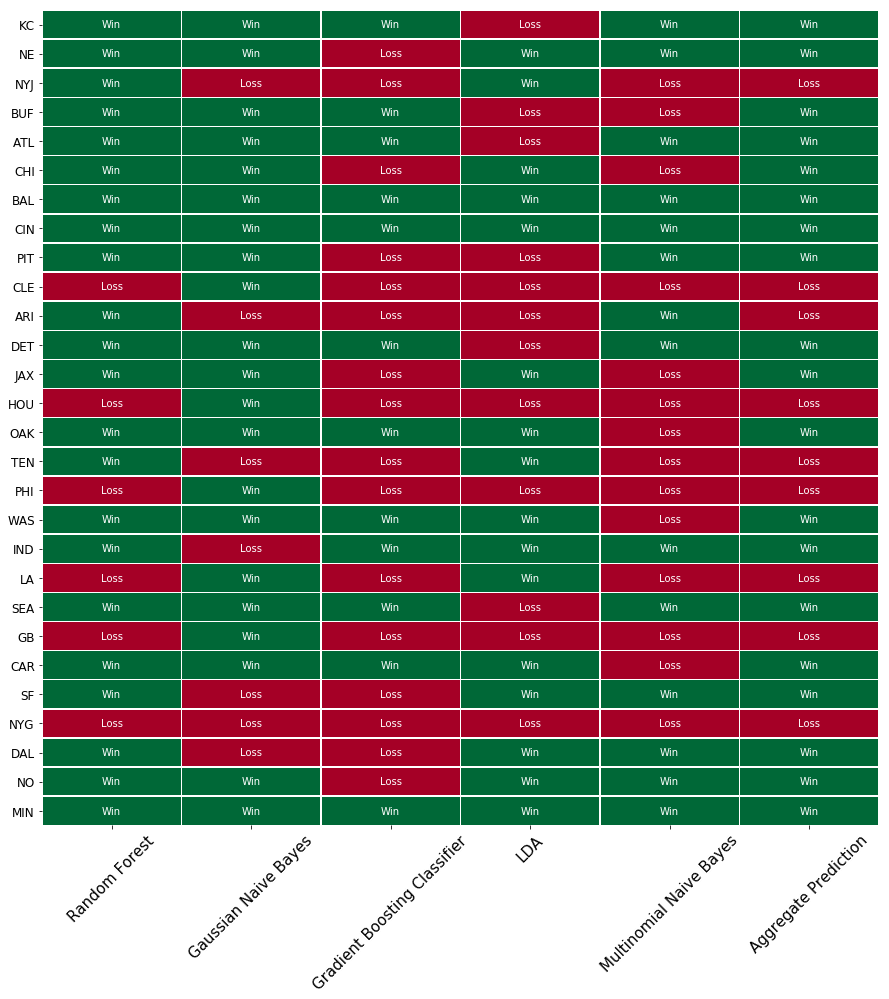

In [12]:
week1PlottingPredictions['Aggregate Prediction'] = np.where(week1Predictions['Aggregate Prediction'] == 'Win', 1, 0)
plt.figure(figsize=(15,15))
sns.heatmap(week1PlottingPredictions, annot=week1Predictions, linewidths=.5, cmap='RdYlGn', cbar=False, fmt="s")
plt.xticks(rotation=45, size=15)
plt.yticks(rotation=0, size=12)
plt.show()